# Predicting the Frequency of Crimes in Chicago

Chicago is one of the largest cities in the United States, and thus is inevitably subject to crime. However, learning how often crimes are committed on a daily basis can have a significant impact on mitigating them. This notebook will attempt to answer this question, and provide invaluable insight into where and when different crimes are committed.

Before starting, I imported the necessary libraries for the project.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Data Wrangling and Data Cleaning

The data are spread amongst several csv files and have some errors that will inhibit the project later. Further, the features are not in the most interpretable format. Thus, before starting any data analysis, data wrangling and cleaning must be performed.

First, concatenating all of the data into a single Pandas DataFrame.

In [2]:
df = pd.DataFrame()
for year in np.arange(2010,2023,1):
    df_year = pd.read_csv("/kaggle/input/crimes-in-chicago/" + str(year) + ".csv",
                         parse_dates = ['Date'])
    df = pd.concat([df, df_year], axis=0)

In [3]:
df.head()

ID Case Number       Date                   Block  IUCR  \
0  11039140    JA371686 2010-01-01    055XX W FARRAGUT AVE  1753   
1  10342825    HY533211 2010-01-01    056XX W EASTWOOD AVE  1752   
2  10938629    JA251783 2010-01-01  043XX N MONTICELLO AVE  1753   
3  11262896    JB194570 2010-01-01     057XX N ROCKWELL ST  0266   
4  11875312    JC490052 2010-01-01         017XX W 48TH ST  1752   

                 Primary Type                    Description  \
0  OFFENSE INVOLVING CHILDREN  SEX ASSLT OF CHILD BY FAM MBR   
1  OFFENSE INVOLVING CHILDREN  AGG CRIM SEX ABUSE FAM MEMBER   
2  OFFENSE INVOLVING CHILDREN  SEX ASSLT OF CHILD BY FAM MBR   
3         CRIM SEXUAL ASSAULT                      PREDATORY   
4  OFFENSE INVOLVING CHILDREN  AGG CRIM SEX ABUSE FAM MEMBER   

  Location Description  Arrest  Domestic  ...  Ward  Community Area  FBI Code  \
0            RESIDENCE   False     False  ...  45.0            11.0        02   
1            RESIDENCE   False      True  ...  45.0            15.0        20   
2            RESIDENCE   False     False  ...  33.0            16.0        02   
3                OTHER    True     False  ...  40.0             2.0        02   
4            APARTMENT   False     False  ...  15.0            61.0        17   

   X Coordinate Y Coordinate  Year              Updated On   Latitude  \
0           NaN          NaN  2010  08/02/2017 03:54:51 PM        NaN   
1     1137897.0    1930354.0  2010  02/10/2018 03:50:01 PM  41.965032   
2           NaN          NaN  2010  05/09/2017 03:54:21 PM        NaN   
3           NaN          NaN  2010  10/22/2019 04:01:10 PM        NaN   
4           NaN          NaN  2010  10/29/2019 03:51:02 PM        NaN   

   Longitude                      Location  
0        NaN                           NaN  
1 -87.768376  (41.96503178, -87.768375694)  
2        NaN                           NaN  
3        NaN                           NaN  
4        NaN                           NaN  

[5 rows x 22 columns]

Many of the reported crimes are missing coordinates. So, these instances will be dropped so calculations and visualizations can be done later.

In [4]:
df = df.dropna()

df.head()

ID Case Number       Date                   Block  IUCR  \
1   10342825    HY533211 2010-01-01    056XX W EASTWOOD AVE  1752   
5   11033112    JA366109 2010-01-01         047XX S WOOD ST  1562   
8    7296936    HS100025 2010-01-01      031XX W MADISON ST  0486   
9    7296951    HS100091 2010-01-01  089XX S BLACKSTONE AVE  1310   
10   7297081    HS100411 2010-01-01   046XX S WENTWORTH AVE  0620   

                  Primary Type                    Description  \
1   OFFENSE INVOLVING CHILDREN  AGG CRIM SEX ABUSE FAM MEMBER   
5                  SEX OFFENSE      AGG CRIMINAL SEXUAL ABUSE   
8                      BATTERY        DOMESTIC BATTERY SIMPLE   
9              CRIMINAL DAMAGE                    TO PROPERTY   
10                    BURGLARY                 UNLAWFUL ENTRY   

       Location Description  Arrest  Domestic  ...  Ward  Community Area  \
1                 RESIDENCE   False      True  ...  45.0            15.0   
5                 RESIDENCE   False      True  ...  15.0            61.0   
8                 RESIDENCE   False      True  ...  28.0            27.0   
9                 APARTMENT   False     False  ...   8.0            48.0   
10  RESIDENCE PORCH/HALLWAY   False     False  ...   3.0            37.0   

    FBI Code  X Coordinate Y Coordinate  Year              Updated On  \
1         20     1137897.0    1930354.0  2010  02/10/2018 03:50:01 PM   
5         17     1165145.0    1873300.0  2010  06/28/2019 04:19:07 PM   
8        08B     1155440.0    1899850.0  2010  02/10/2018 03:50:01 PM   
9         14     1187677.0    1846002.0  2010  02/10/2018 03:50:01 PM   
10        05     1175413.0    1874160.0  2010  02/10/2018 03:50:01 PM   

     Latitude  Longitude                       Location  
1   41.965032 -87.768376   (41.96503178, -87.768375694)  
5   41.807934 -87.669813   (41.807934431, -87.66981324)  
8   41.880991 -87.704696  (41.880990844, -87.704696121)  
9   41.732519 -87.588040    (41.7325193, -87.588040183)  
10  41.810071 -87.632127  (41.810070644, -87.632127284)  

[5 rows x 22 columns]

The logged date of when the crime was reported is not in an optimal format. Using Pandas' to_datetime() function will do this easily and efficiently.

In [5]:
df['Dates'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = pd.to_datetime(df['Date']).dt.time

When visualizing the trend in the frequency of crimes, as well as other time-varying factors, creating a time dummy variable is imperative. In this case, 0 will correspond to the first date in the dataset (01-01-2010), and 4763 will correspond to the last date in the dataset (12-07-2022).

In [6]:
df['Time_Dummy_Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
df['Time_Dummy_Date'].replace(to_replace=df['Time_Dummy_Date'].unique(),
                  value=list(range(len(df['Time_Dummy_Date'].unique()))),
                  inplace=True)

The resulting dataframe is incredibly memory intensive, so to save time in future sessions, it will be converted into a csv file and saved.

In [8]:
df.head()

ID Case Number       Date                   Block  IUCR  \
1   10342825    HY533211 2010-01-01    056XX W EASTWOOD AVE  1752   
5   11033112    JA366109 2010-01-01         047XX S WOOD ST  1562   
8    7296936    HS100025 2010-01-01      031XX W MADISON ST  0486   
9    7296951    HS100091 2010-01-01  089XX S BLACKSTONE AVE  1310   
10   7297081    HS100411 2010-01-01   046XX S WENTWORTH AVE  0620   

                  Primary Type                    Description  \
1   OFFENSE INVOLVING CHILDREN  AGG CRIM SEX ABUSE FAM MEMBER   
5                  SEX OFFENSE      AGG CRIMINAL SEXUAL ABUSE   
8                      BATTERY        DOMESTIC BATTERY SIMPLE   
9              CRIMINAL DAMAGE                    TO PROPERTY   
10                    BURGLARY                 UNLAWFUL ENTRY   

       Location Description  Arrest  Domestic  ...  X Coordinate  \
1                 RESIDENCE   False      True  ...     1137897.0   
5                 RESIDENCE   False      True  ...     1165145.0   
8                 RESIDENCE   False      True  ...     1155440.0   
9                 APARTMENT   False     False  ...     1187677.0   
10  RESIDENCE PORCH/HALLWAY   False     False  ...     1175413.0   

    Y Coordinate  Year              Updated On   Latitude  Longitude  \
1      1930354.0  2010  02/10/2018 03:50:01 PM  41.965032 -87.768376   
5      1873300.0  2010  06/28/2019 04:19:07 PM  41.807934 -87.669813   
8      1899850.0  2010  02/10/2018 03:50:01 PM  41.880991 -87.704696   
9      1846002.0  2010  02/10/2018 03:50:01 PM  41.732519 -87.588040   
10     1874160.0  2010  02/10/2018 03:50:01 PM  41.810071 -87.632127   

                         Location       Dates      Time  Time_Dummy_Date  
1    (41.96503178, -87.768375694)  2010-01-01  00:00:00                0  
5    (41.807934431, -87.66981324)  2010-01-01  00:00:00                0  
8   (41.880990844, -87.704696121)  2010-01-01  00:00:00                0  
9     (41.7325193, -87.588040183)  2010-01-01  00:00:00                0  
10  (41.810070644, -87.632127284)  2010-01-01  00:00:00                0  

[5 rows x 25 columns]

In [9]:
df.to_csv("concatenated_df_cleaned.csv")
df.to_csv("concatenated_df_original.csv")

# Exploratory Data Analysis

Now, for some EDA. This is a large dataset covering over a decade of reported crimes, so there is much to be learned before modeling can be done.

First, importing the datasets created in the last section. The cleaned dataset will be used specifically for plots (many of the crimes reported do not have coordinates included, but all data are there), whereas the original dataset will be used for quantitive analysis.

In [10]:
cleaned_df = pd.read_csv('/kaggle/input/crime-datasets/concatenated_df_cleaned.csv')
original_df = pd.read_csv('/kaggle/input/crime-datasets/concatenated_df_original.csv')

cleaned_df = cleaned_df[cleaned_df['X Coordinate'] > 1e6]

A shape file of Chicago helps to visualize the area that the data covers. On this shape file, the city is divided up into community areas.

<AxesSubplot:>

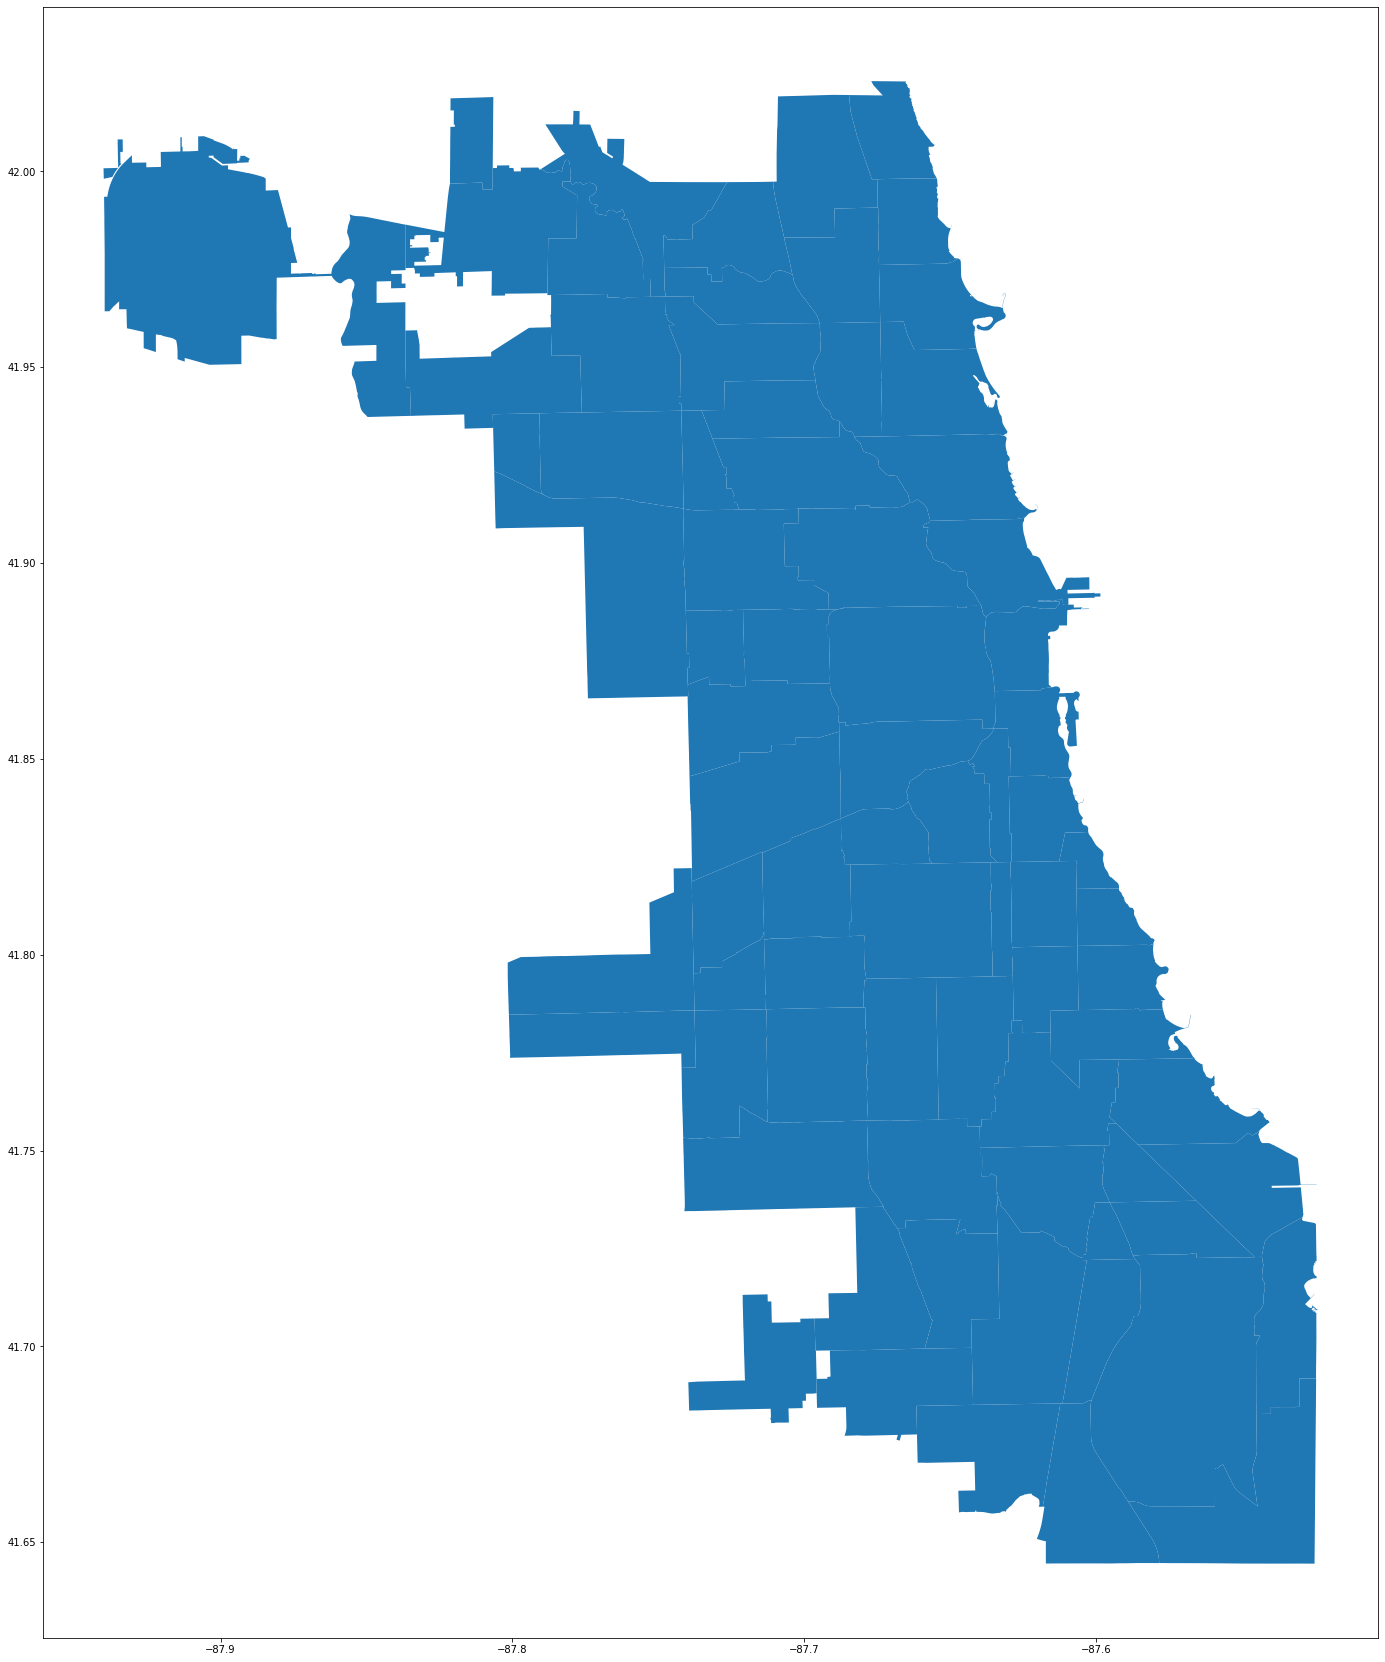

In [11]:
crime_geo_map = gpd.read_file('/kaggle/input/shapefile/geo_export_e6c26f75-97af-4f42-80de-e3d5a09b36bb.shp')

fig,ax = plt.subplots(figsize = (30,30))
crime_geo_map.plot(ax = ax)

The distribution of crimes committed based on ward.

In [12]:
original_df['Ward'].value_counts()

42.0    174318
28.0    170135
24.0    151746
27.0    138319
6.0     123947
17.0    120094
2.0     119553
20.0    113089
21.0    110723
8.0     103053
16.0    100633
7.0     100400
34.0     98637
3.0      97644
37.0     97417
9.0      96911
5.0      87297
29.0     85959
15.0     85195
4.0      72992
1.0      65813
10.0     61755
18.0     58352
26.0     56308
32.0     56176
25.0     55604
44.0     55373
49.0     50813
14.0     47815
46.0     47758
31.0     47619
11.0     47354
30.0     46430
43.0     45932
12.0     44384
35.0     44116
22.0     43379
13.0     42184
23.0     41222
41.0     40549
36.0     38150
40.0     38091
50.0     37948
45.0     37452
47.0     36312
38.0     36289
48.0     35811
33.0     35393
39.0     34344
19.0     31266
Name: Ward, dtype: int64

A plot of all crimes, color coded by the ward in which they occured.

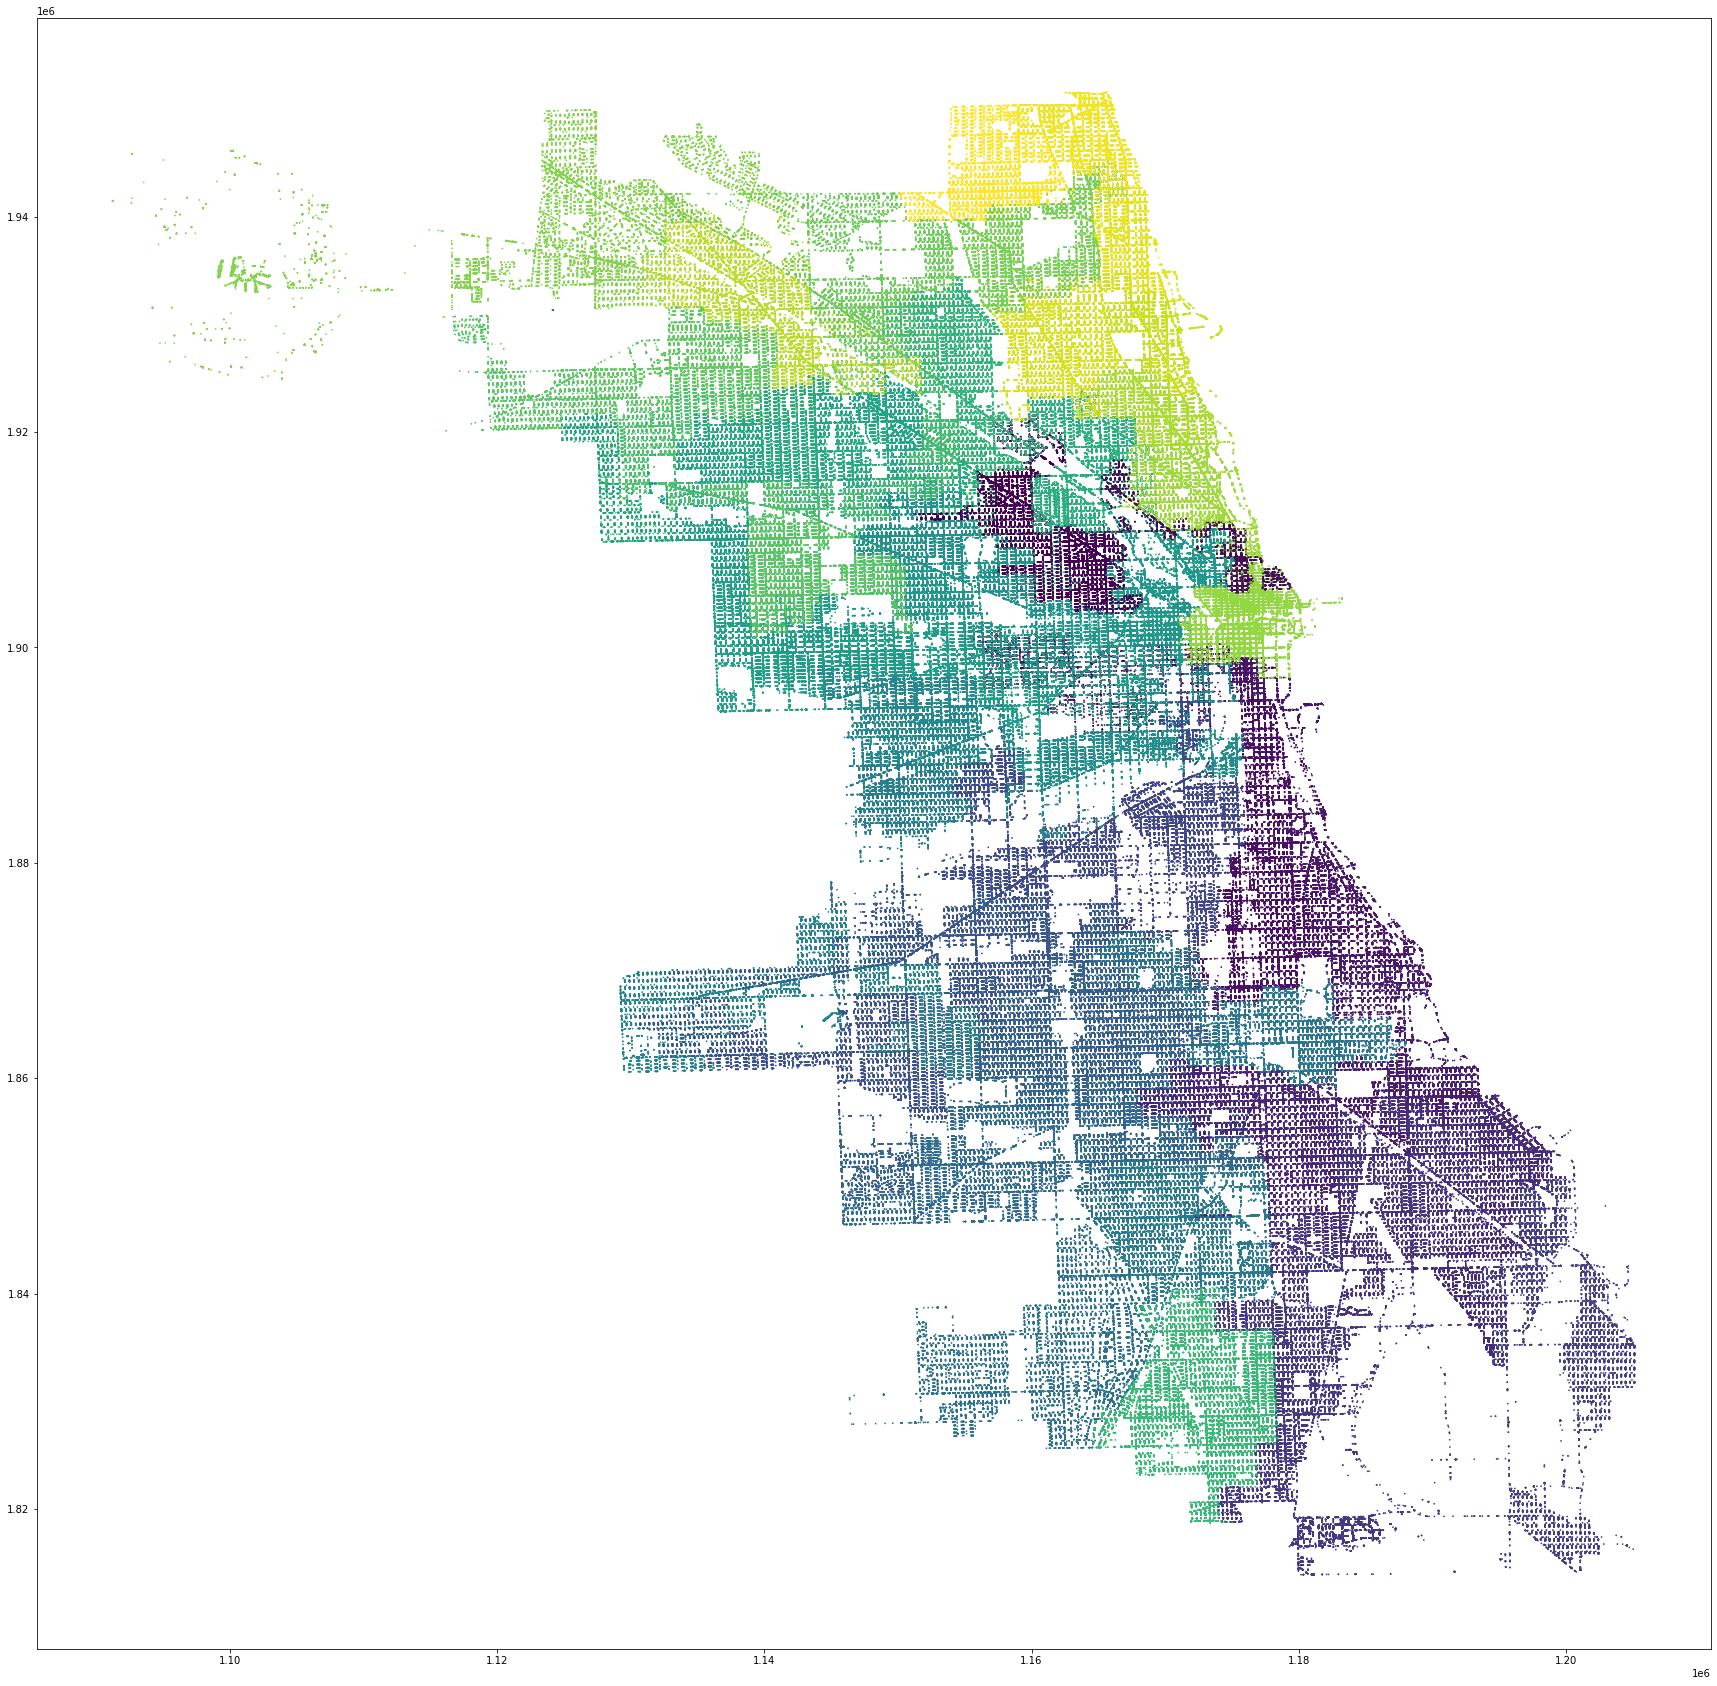

In [13]:
fig,ax = plt.subplots(figsize = (30,30))

plt.scatter(cleaned_df['X Coordinate'], cleaned_df['Y Coordinate'], s=0.5, c=cleaned_df['Ward'])

How many of each type of crime occured.

In [14]:
original_df['Primary Type'].value_counts()

THEFT                                803057
BATTERY                              655296
CRIMINAL DAMAGE                      390196
NARCOTICS                            274232
ASSAULT                              250574
OTHER OFFENSE                        220471
DECEPTIVE PRACTICE                   211812
BURGLARY                             192176
MOTOR VEHICLE THEFT                  168500
ROBBERY                              138168
CRIMINAL TRESPASS                     86601
WEAPONS VIOLATION                     66620
OFFENSE INVOLVING CHILDREN            29937
PUBLIC PEACE VIOLATION                26594
PROSTITUTION                          15295
SEX OFFENSE                           14185
CRIM SEXUAL ASSAULT                   13543
INTERFERENCE WITH PUBLIC OFFICER      13267
HOMICIDE                               7593
ARSON                                  5915
CRIMINAL SEXUAL ASSAULT                5719
LIQUOR LAW VIOLATION                   4508
GAMBLING                        

A plot of all theft crimes committed, on top of all crimes committed over the 12 year period. There is a large concentration of theft in the downtown area.

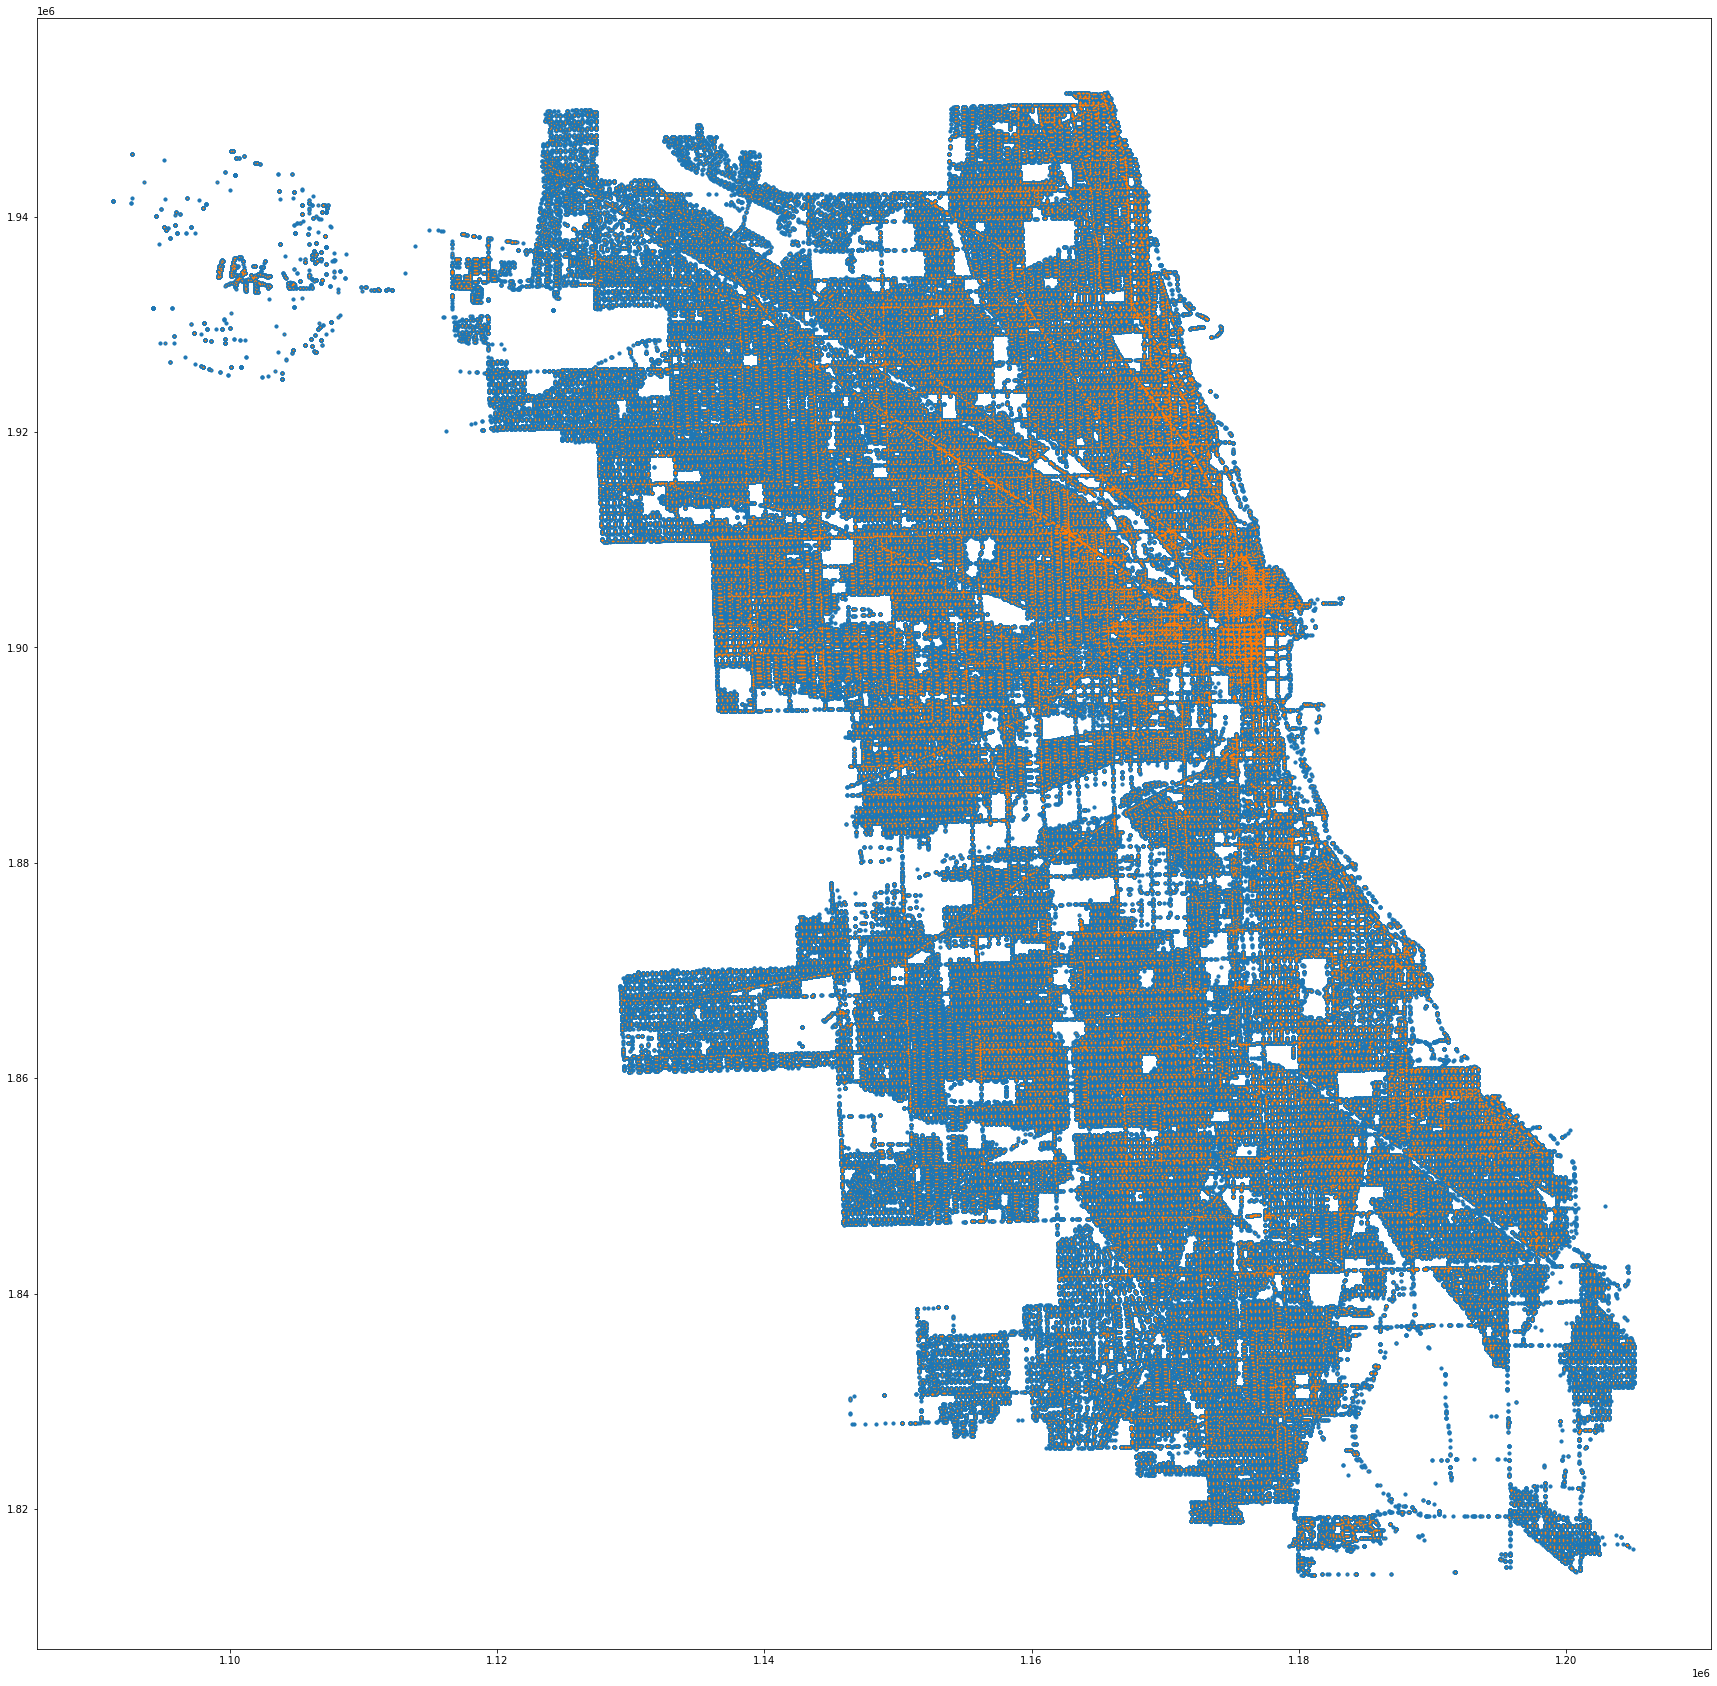

In [15]:
fig,ax = plt.subplots(figsize = (30,30))

most_common_crimes = list(cleaned_df['Primary Type'].value_counts().index)[:1]

plt.scatter(cleaned_df['X Coordinate'], cleaned_df['Y Coordinate'], s=10)
plt.scatter(cleaned_df[cleaned_df['Primary Type'].isin(most_common_crimes)]['X Coordinate'],
           cleaned_df[cleaned_df['Primary Type'].isin(most_common_crimes)]['Y Coordinate'],
           s=.05)

Most common location of crimes.

In [16]:
original_df['Location Description'].value_counts().head(20)

STREET                            844413
RESIDENCE                         586435
APARTMENT                         494985
SIDEWALK                          344524
OTHER                             113899
PARKING LOT/GARAGE(NON.RESID.)     86373
SMALL RETAIL STORE                 79079
ALLEY                              77288
RESTAURANT                         68653
VEHICLE NON-COMMERCIAL             60625
RESIDENTIAL YARD (FRONT/BACK)      59144
RESIDENCE PORCH/HALLWAY            52004
RESIDENCE-GARAGE                   51834
SCHOOL, PUBLIC, BUILDING           51298
DEPARTMENT STORE                   51201
GAS STATION                        42477
GROCERY FOOD STORE                 40450
PARK PROPERTY                      27743
COMMERCIAL / BUSINESS OFFICE       24206
BAR OR TAVERN                      23772
Name: Location Description, dtype: int64

The 10 community areas where the most crimes occur.

In [17]:
original_df['Community Area'].value_counts().head(10)

25.0    222537
8.0     136076
43.0    122121
29.0    114319
28.0    112627
23.0    112294
32.0    105068
71.0    102969
24.0    102491
67.0     98903
Name: Community Area, dtype: int64

In [18]:
residence_crimes = original_df[original_df['Location Description'] == 'RESIDENCE']
#residence_crimes_non_domestic = residence_crimes[residence_crimes['Domestic'] == False]
residence_crimes = residence_crimes[residence_crimes['Primary Type'].isin(['THEFT','ROBBERY', 'BURGLARY'])]

residence_crimes
#100 * residence_crimes['Primary Type'].value_counts() / len(residence_crimes.index)

Unnamed: 0        ID Case Number                 Date  \
21               21   7334488    HS137665  2010-01-01 00:00:00   
24               24   7349288    HS150733  2010-01-01 00:00:00   
26               26   7352414    HS154078  2010-01-01 00:00:00   
34               34   7390822    HS192754  2010-01-01 00:00:00   
37               37   7431234    HS233216  2010-01-01 00:00:00   
...             ...       ...         ...                  ...   
3607878      220278  12916396    JF501902  2022-12-07 15:30:00   
3608009      220409  12915823    JF502090  2022-12-07 19:10:00   
3608039      220439  12916013    JF502414  2022-12-07 20:00:00   
3608049      220449  12917391    JF502367  2022-12-07 20:30:00   
3608063      220463  12916889    JF503010  2022-12-07 21:00:00   

                          Block  IUCR Primary Type  \
21            057XX N WAYNE AVE  0841        THEFT   
24         082XX S MUSKEGON AVE  0843        THEFT   
26           078XX S PAXTON AVE  0841        THEFT   
34          015XX S KOSTNER AVE  0840        THEFT   
37         023XX W MONTROSE AVE  0840        THEFT   
...                         ...   ...          ...   
3607878       026XX N MEADE AVE  0620     BURGLARY   
3608009      122XX S JUSTINE ST  0620     BURGLARY   
3608039   013XX W FULLERTON AVE  0810        THEFT   
3608049  054XX S UNIVERSITY AVE  0620     BURGLARY   
3608063     026XX W WARREN BLVD  0810        THEFT   

                              Description Location Description  Arrest  ...  \
21         FINANCIAL ID THEFT:$300 &UNDER            RESIDENCE   False  ...   
24       ATTEMPT FINANCIAL IDENTITY THEFT            RESIDENCE   False  ...   
26         FINANCIAL ID THEFT:$300 &UNDER            RESIDENCE   False  ...   
34          FINANCIAL ID THEFT: OVER $300            RESIDENCE   False  ...   
37          FINANCIAL ID THEFT: OVER $300            RESIDENCE   False  ...   
...                                   ...                  ...     ...  ...   
3607878                    UNLAWFUL ENTRY            RESIDENCE   False  ...   
3608009                    UNLAWFUL ENTRY            RESIDENCE   False  ...   
3608039                         OVER $500            RESIDENCE   False  ...   
3608049                    UNLAWFUL ENTRY            RESIDENCE   False  ...   
3608063                         OVER $500            RESIDENCE   False  ...   

         Y Coordinate  Year              Updated On   Latitude  Longitude  \
21          1938168.0  2010  02/10/2018 03:50:01 PM  41.985909 -87.663216   
24          1850949.0  2010  02/10/2018 03:50:01 PM  41.745878 -87.555214   
26          1853516.0  2010  02/10/2018 03:50:01 PM  41.753029 -87.571132   
34          1892165.0  2010  02/10/2018 03:50:01 PM  41.860062 -87.734775   
37          1929158.0  2010  02/10/2018 03:50:01 PM  41.961325 -87.687862   
...               ...   ...                     ...        ...        ...   
3607878     1916895.0  2022  12/14/2022 03:49:33 PM  41.928146 -87.778296   
3608009     1823731.0  2022  12/14/2022 03:49:33 PM  41.671844 -87.659987   
3608039     1916058.0  2022  12/14/2022 03:49:33 PM  41.925231 -87.662514   
3608049     1869597.0  2022  12/14/2022 03:49:33 PM  41.797336 -87.598130   
3608063     1900250.0  2022  12/14/2022 03:49:33 PM  41.882024 -87.693049   

                              Location       Dates      Time  Time_Dummy_Date  \
21       (41.985909308, -87.663216202)  2010-01-01  00:00:00                0   
24       (41.745877762, -87.555213717)  2010-01-01  00:00:00                0   
26       (41.753029081, -87.571131654)  2010-01-01  00:00:00                0   
34       (41.860061968, -87.734775323)  2010-01-01  00:00:00                0   
37       (41.961325267, -87.687861751)  2010-01-01  00:00:00                0   
...                                ...         ...       ...              ...   
3607878  (41.928145714, -87.778296311)  2022-12-07  15:30:00             4723   
3608009  (41.671844491, -87.659986787)  2022-

In [19]:
trend_residential_crimes = pd.DataFrame(residence_crimes['Time_Dummy_Date'].value_counts())
trend_residential_crimes.index.name = 'day'

trend_residential_crimes = trend_residential_crimes.sort_values('day')

trend_residential_crimes

Time_Dummy_Date
day                  
0                 144
1                  33
2                  17
3                  44
4                  53
...               ...
4719               10
4720               14
4721               23
4722               15
4723               15

[4717 rows x 1 columns]

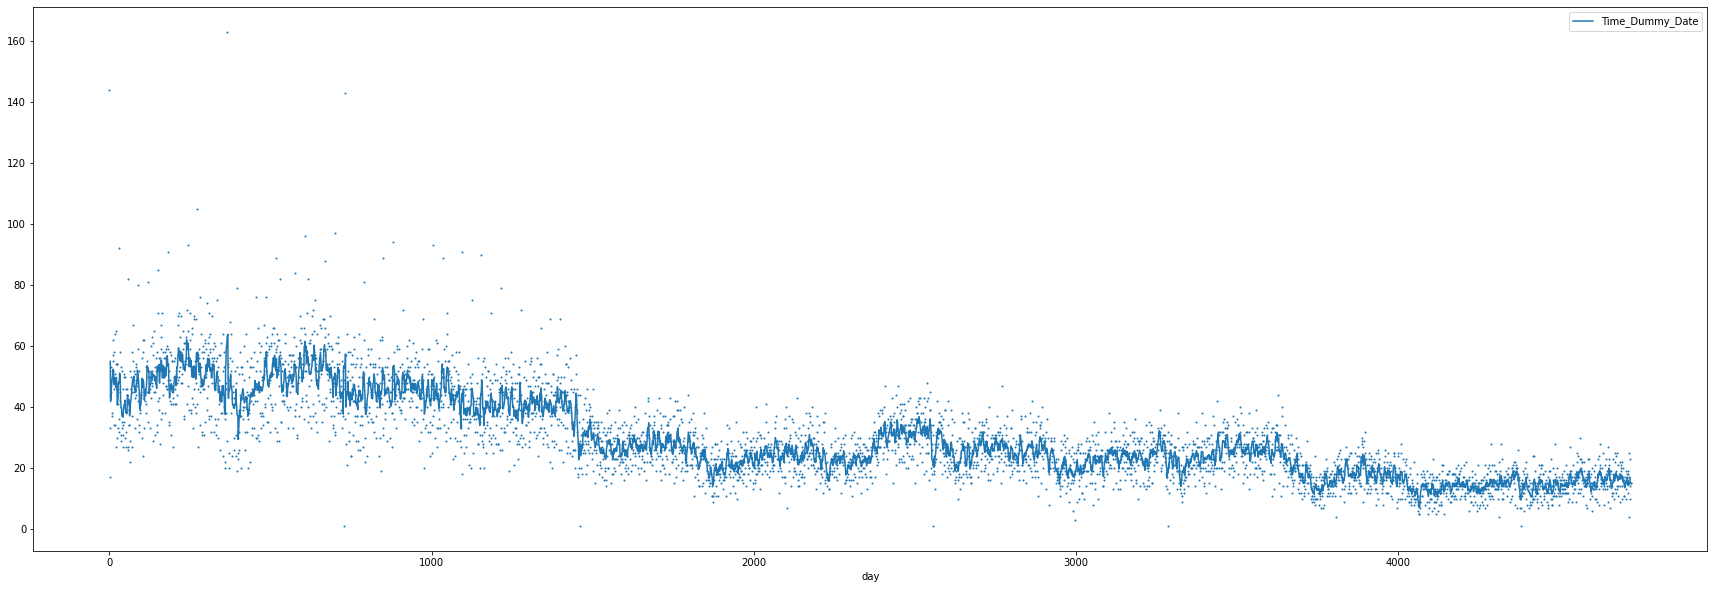

In [20]:
fig,ax = plt.subplots(figsize = (30,10))
plt.scatter(list(trend_residential_crimes.index), trend_residential_crimes['Time_Dummy_Date'], s=1)

trend_line_residential = trend_residential_crimes.rolling(
                            window=7,
                            center=True).mean()

ax = trend_line_residential.plot(ax=ax)

In [21]:
residence_crimes['Community Area'].value_counts()

25.0    6850
49.0    6548
67.0    6296
71.0    5342
53.0    4603
        ... 
37.0     330
34.0     323
36.0     318
76.0     255
9.0      216
Name: Community Area, Length: 77, dtype: int64

Not much of a trend here.

<AxesSubplot:>

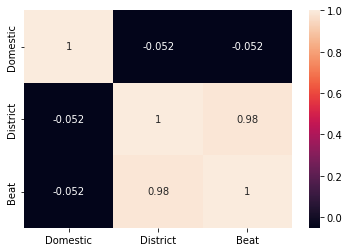

In [22]:
sns.heatmap(residence_crimes[['Domestic', 'District', 'Beat', 'Primary Type']].corr(), annot=True)

In [23]:
residence_crimes['District'].value_counts()

8.0     13051
4.0     11242
5.0     10874
7.0     10689
6.0      9723
22.0     8737
25.0     7649
16.0     6382
9.0      6094
3.0      5925
19.0     5873
11.0     5437
12.0     5114
2.0      4780
14.0     4469
15.0     4395
10.0     4148
17.0     4124
24.0     3487
18.0     3108
20.0     2082
1.0      1641
31.0        1
Name: District, dtype: int64

The 10 blocks where the most crimes occur.

In [24]:
original_df['Block'].value_counts().head(10)

001XX N STATE ST                       9135
0000X W TERMINAL ST                    6327
008XX N MICHIGAN AVE                   5825
0000X N STATE ST                       4694
076XX S CICERO AVE                     4216
064XX S DR MARTIN LUTHER KING JR DR    3337
033XX W FILLMORE ST                    3027
011XX S CANAL ST                       2797
006XX N MICHIGAN AVE                   2638
0000X S STATE ST                       2622
Name: Block, dtype: int64

The location of these 10 blocks. It appears the majority of these blocks are located in the downtown area and around O'Hare International Airport.

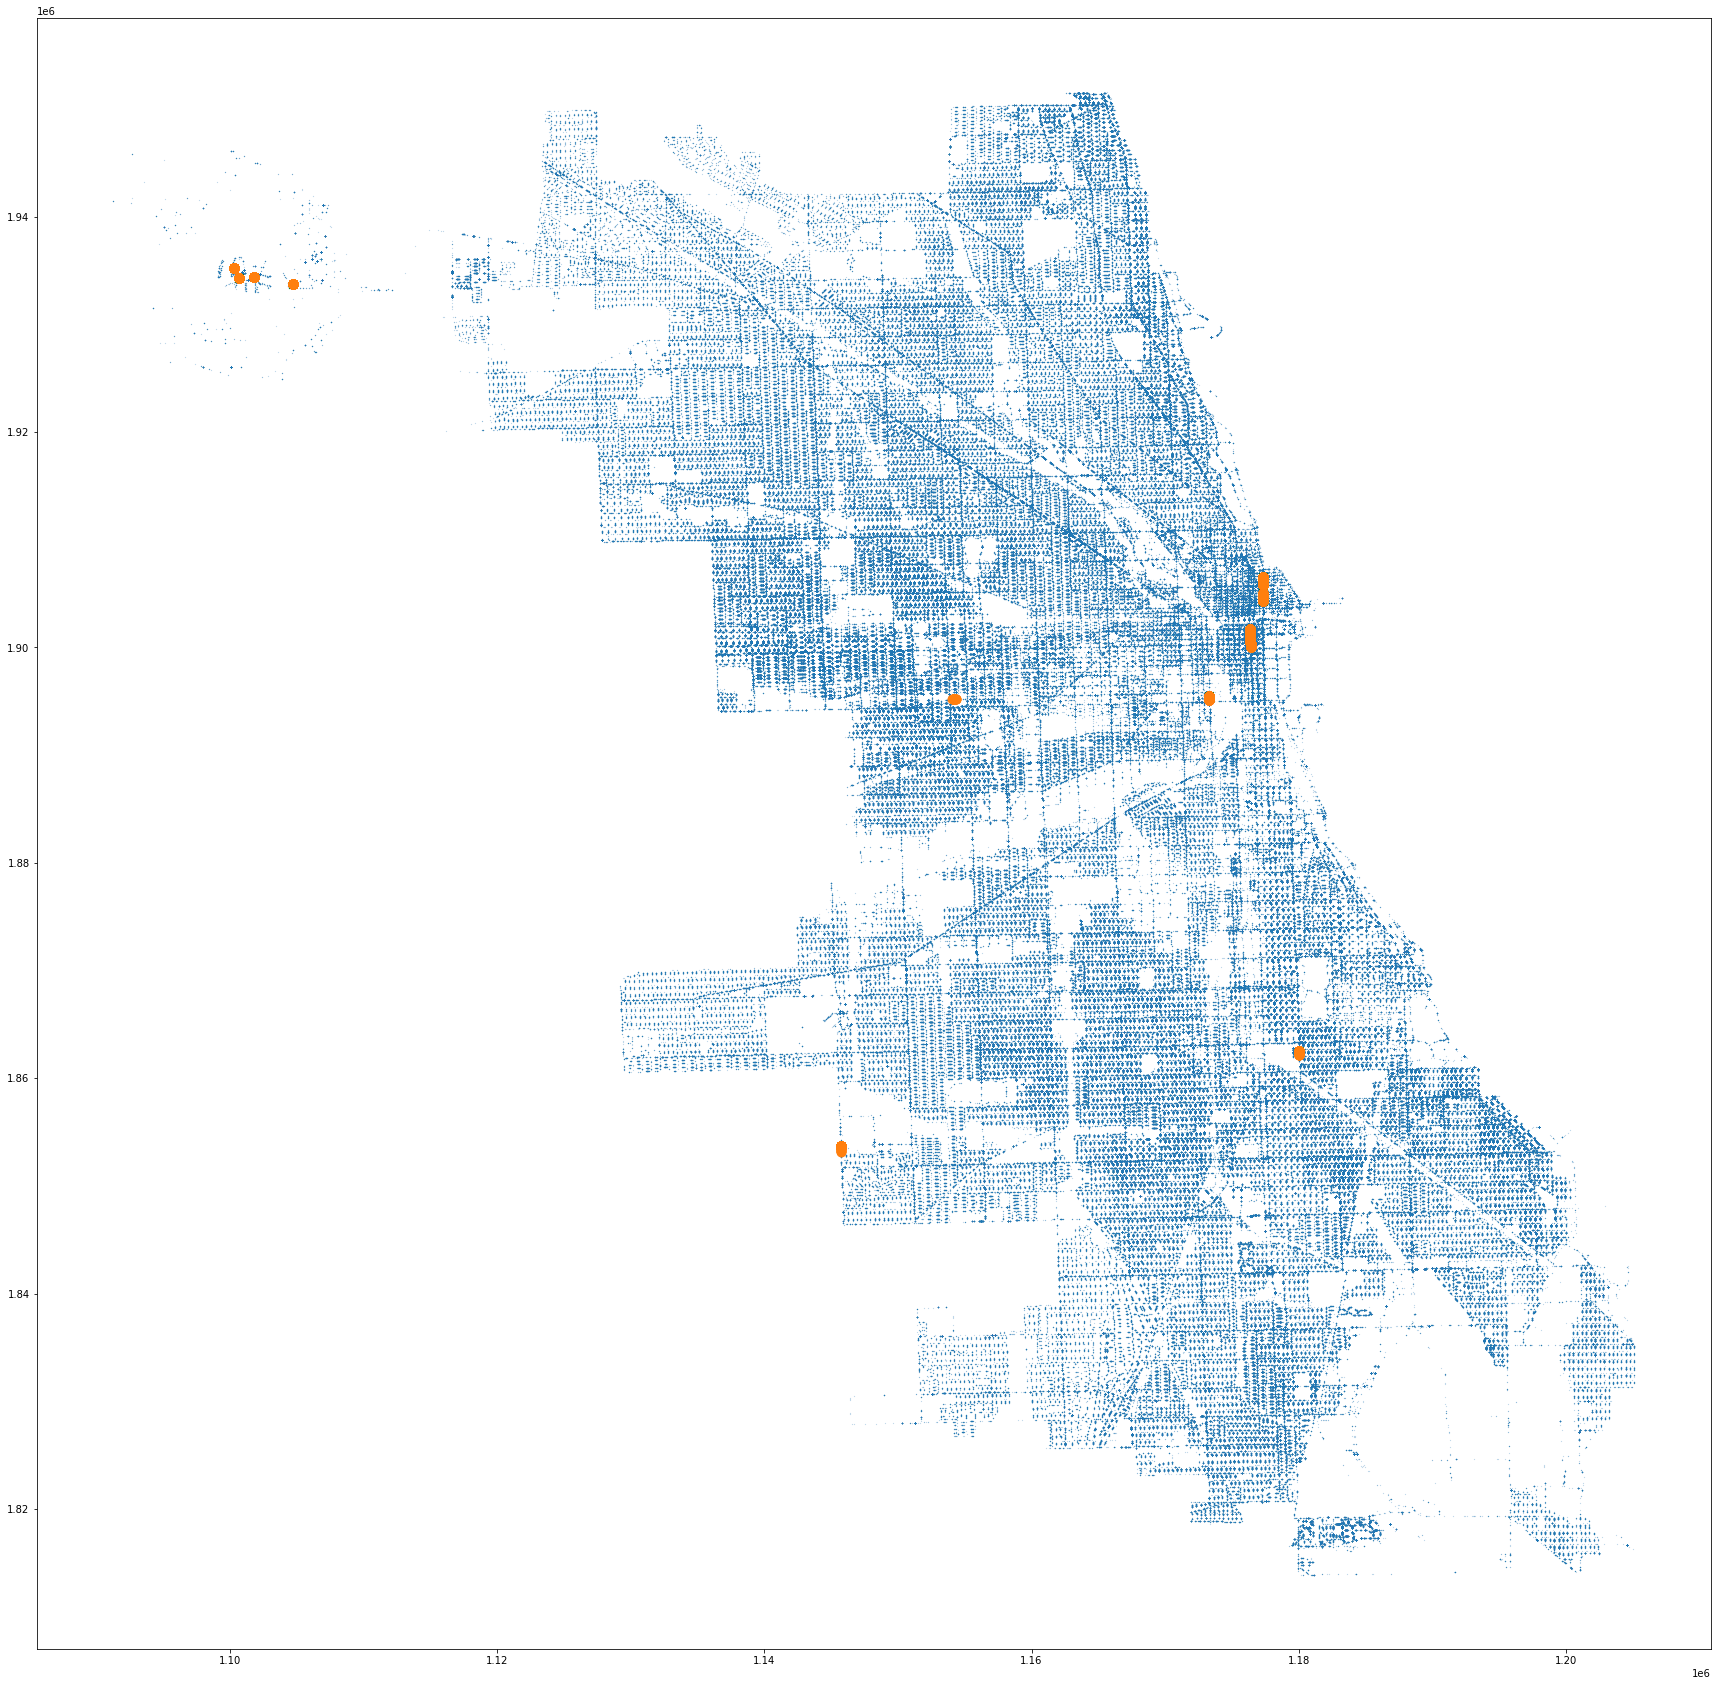

In [25]:
blocks_most_crime = list(original_df['Block'].value_counts().index)[:10]

fig,ax = plt.subplots(figsize = (30,30))
plt.scatter(cleaned_df['X Coordinate'], cleaned_df['Y Coordinate'], s=0.01)
plt.scatter(cleaned_df[cleaned_df['Block'].isin(blocks_most_crime)]['X Coordinate'], cleaned_df[cleaned_df['Block'].isin(blocks_most_crime)]['Y Coordinate'], s=80)

The next few cells explore the trend in crimes committed throughout the year. This will help greatly in answering the question this notebook poses.

In [26]:
trend_date = pd.DataFrame(original_df['Time_Dummy_Date'].value_counts())
trend_date.index.name = 'day'

trend_date = trend_date.sort_values('day')
trend_date

Time_Dummy_Date
day                  
0                1460
1                 793
2                 760
3                 855
4                 912
...               ...
4719              612
4720              646
4721              620
4722              694
4723              676

[4724 rows x 1 columns]

In [27]:
trend_time = pd.DataFrame(original_df['Time_Dummy_Time'].value_counts())
trend_time.index.name = 'time'

trend_time = trend_time.sort_values('time')
trend_time

Time_Dummy_Time
time                     
00:00:00            61164
00:00:33                1
00:00:41                1
00:01:00            41281
00:01:12                1
...                   ...
23:59:21                1
23:59:23                1
23:59:40                1
23:59:45                1
23:59:50                1

[13404 rows x 1 columns]

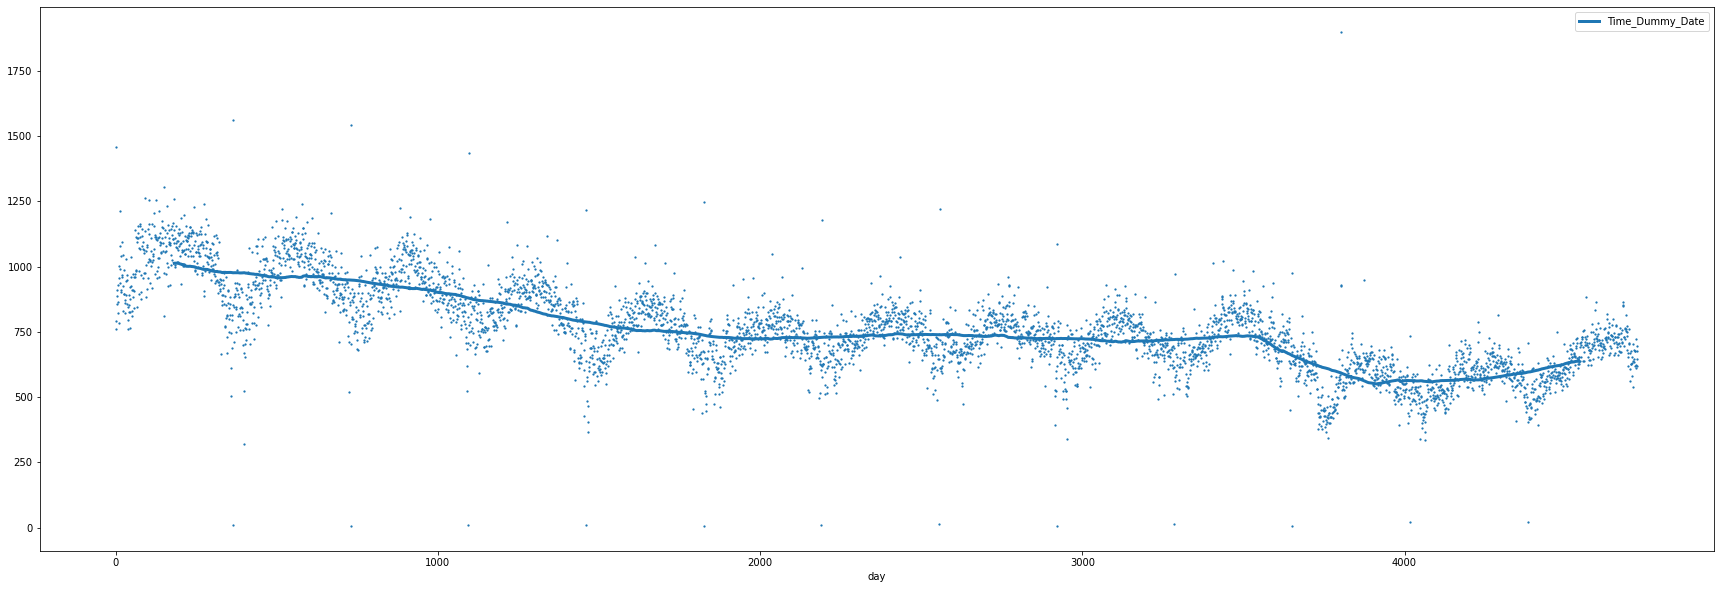

In [28]:
fig,ax = plt.subplots(figsize = (30,10))
plt.scatter(list(trend_date.index), trend_date['Time_Dummy_Date'], s=1.5)

trend_line = trend_date.rolling(
    window=365,
    center=True).mean()

ax = trend_line.plot(ax=ax, linewidth=3)

There is a clear pattern in the number of crimes committed during the course of a year. Evidently, the winter months are when most crime occurs.

Also, it appears that crime as a whole has gradually decreased every year. Further, in 2020, crime dropped drastically, likely due to the Coronavirus Pandemic. Unfortunetely, crime looks to be normalizing as the pandemic continues to wane.

In [29]:
original_df['Year'].value_counts()

2010    369664
2011    351164
2012    335520
2013    306897
2014    275138
2016    269074
2017    268484
2018    268061
2015    264115
2019    260627
2022    220550
2020    211426
2021    207430
Name: Year, dtype: int64

The density of crimes throughout Chicago is not incredibly surprising when considering that the most common crime, theft, overwhelmingly occurs downtown. 

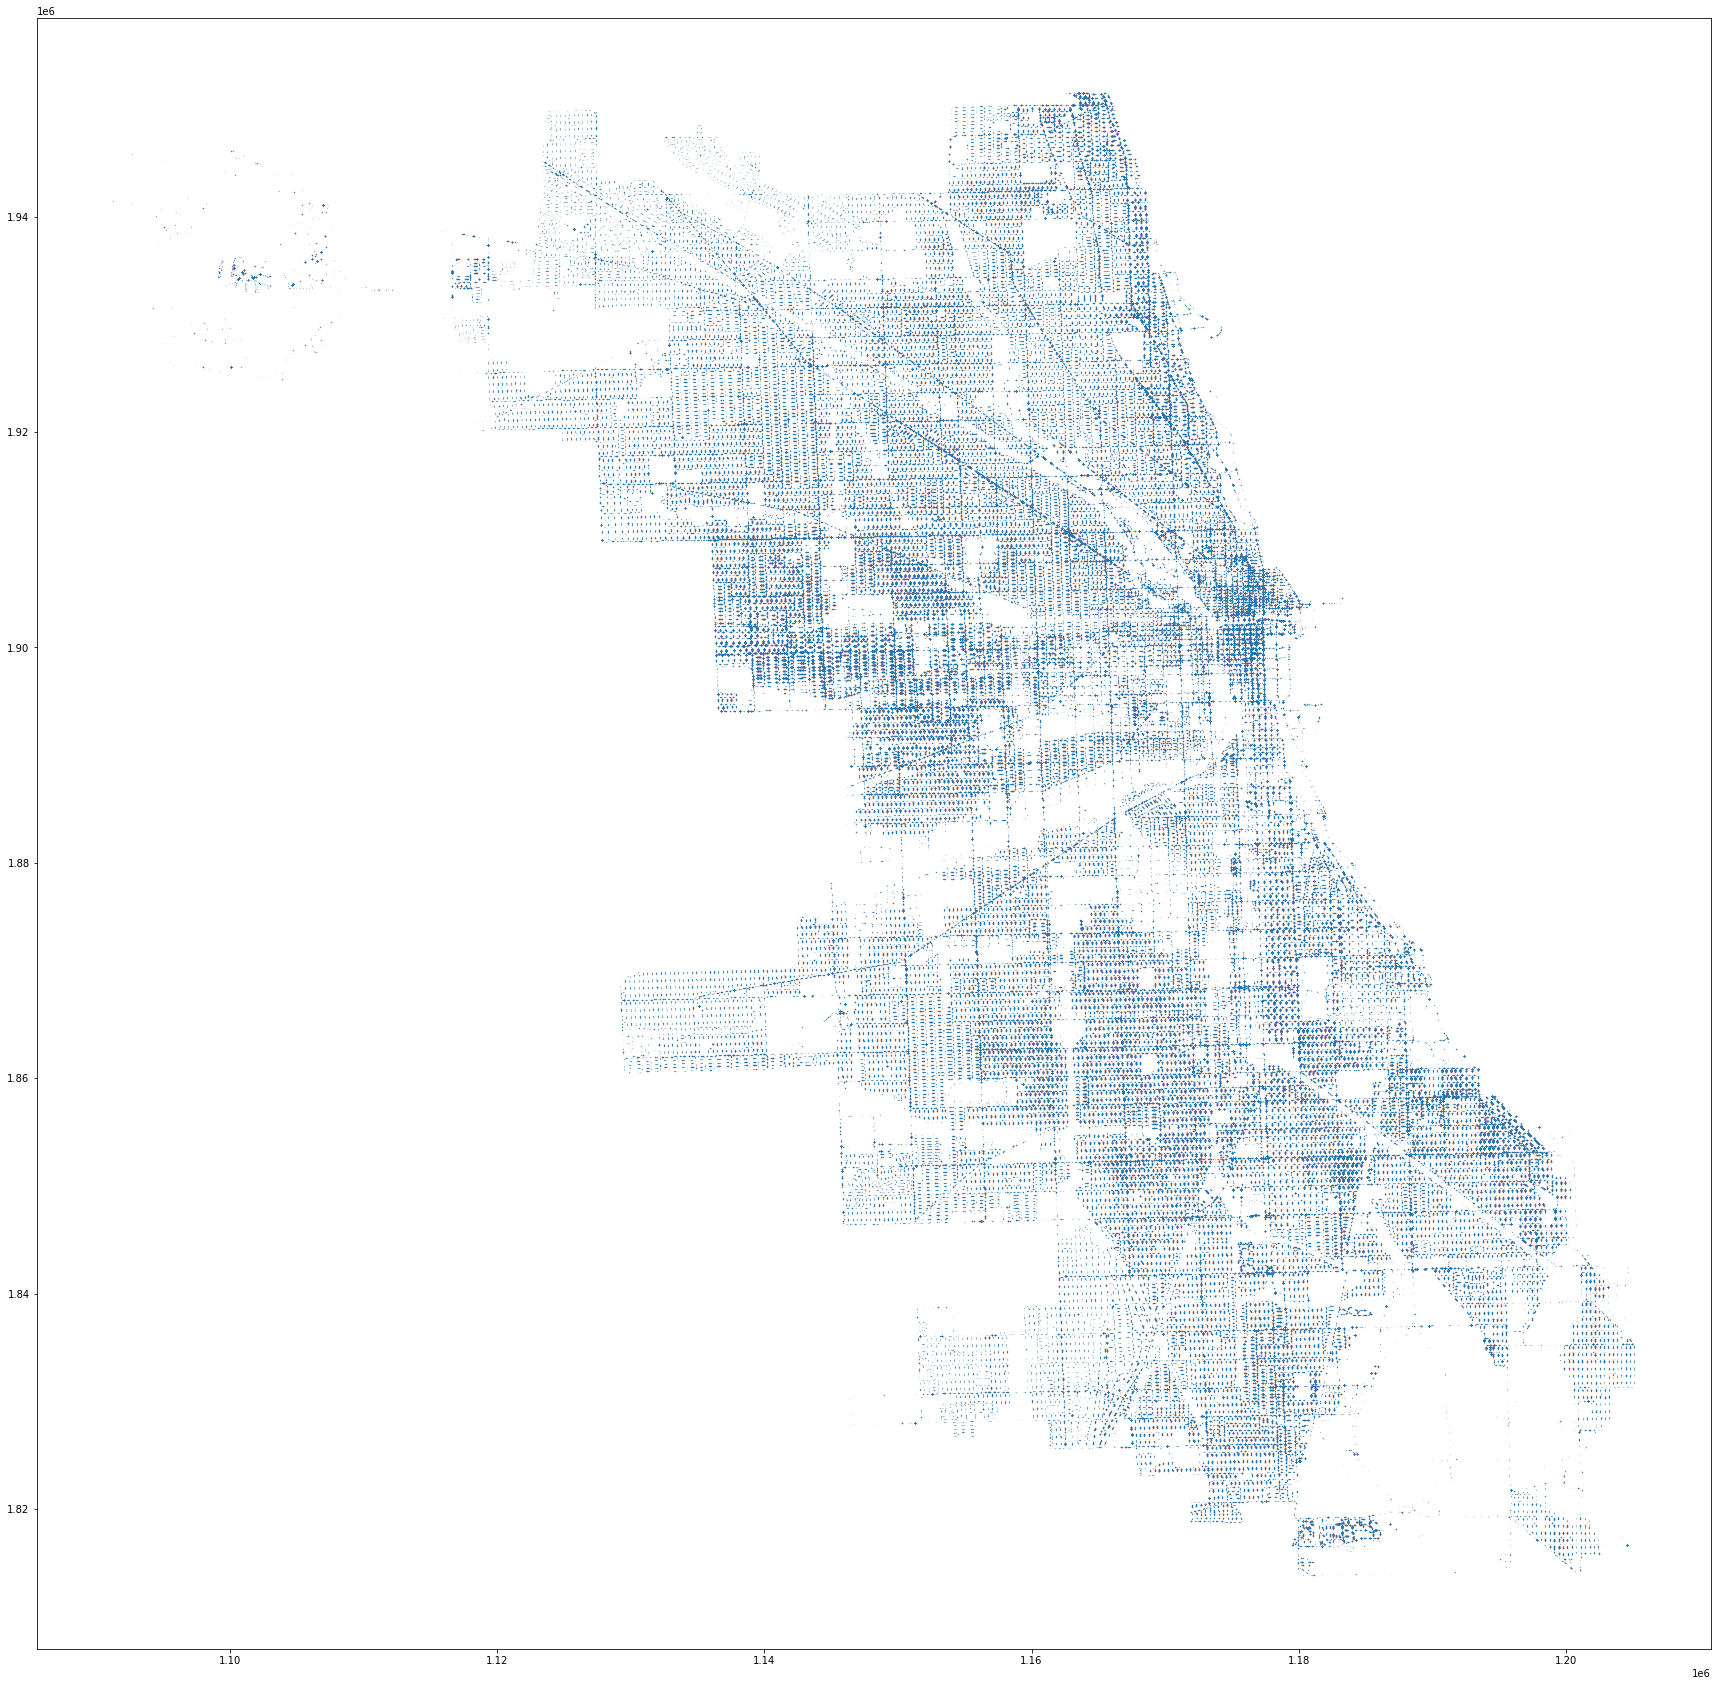

In [30]:
fig,ax = plt.subplots(figsize = (30,30))
plt.scatter(cleaned_df['X Coordinate'], cleaned_df['Y Coordinate'], s=0.001)

# Modeling

I will be working on this section soon. It will primarily concern testing different machine learning models, and optimization.

The target is to estimate the number of theft, burglary, and robbery crimes that will happen in the city based on the day of the year.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

train, test = train_test_split(trend_residential_crimes)

In [32]:
trend_residential_crimes.shape

(4717, 1)

First, linear regression.

In [33]:
model = LinearRegression()

train['day'] = np.array(train.index)

X = train['day'].values.reshape(-1, 1)
y = train['Time_Dummy_Date'].values.reshape(-1,1)

history = model.fit(X, y)

In [34]:
test['day'] = np.array(test.index)
X_test = test['day'].values.reshape(-1,1)

pred = model.predict(X_test)

In [35]:
pred[:10]

array([[42.79880825],
       [11.80362418],
       [38.3512864 ],
       [26.91711205],
       [36.14369829],
       [25.95483005],
       [42.83115386],
       [33.26493869],
       [38.29468158],
       [32.46438476]])

In [36]:
test['Time_Dummy_Date'][:10]

day
703     61
4536    15
1253    46
2667    36
1526    35
2786    37
699     97
1882    11
1260    48
1981    23
Name: Time_Dummy_Date, dtype: int64

Linear Regression is a safe bet that is reasonably accurate.

However, we can do better. The trend looks sinosoidal, so lets fit a curve to that.

The following code uses scipy and trigonometry to determine a reasonable curve for the data. Defining a function called sinusoid() will allow for the calculation of the curve, while curve_fit() determines the parameters for the curve.

In [37]:
def sinusoid(x,A,offset,omega,phase):
 return A*np.sin(omega*x+phase) + offset

#Length of Period in days
T = 365

#Function to get other parameters
def get_p0(x, y):
 A0 = (max(y[0:T]) - min(y[0:T]))/2
 offset0 = y[0]
 phase0 = 0
 omega0 = 2.*np.pi/T
 return [A0, offset0,omega0, phase0]

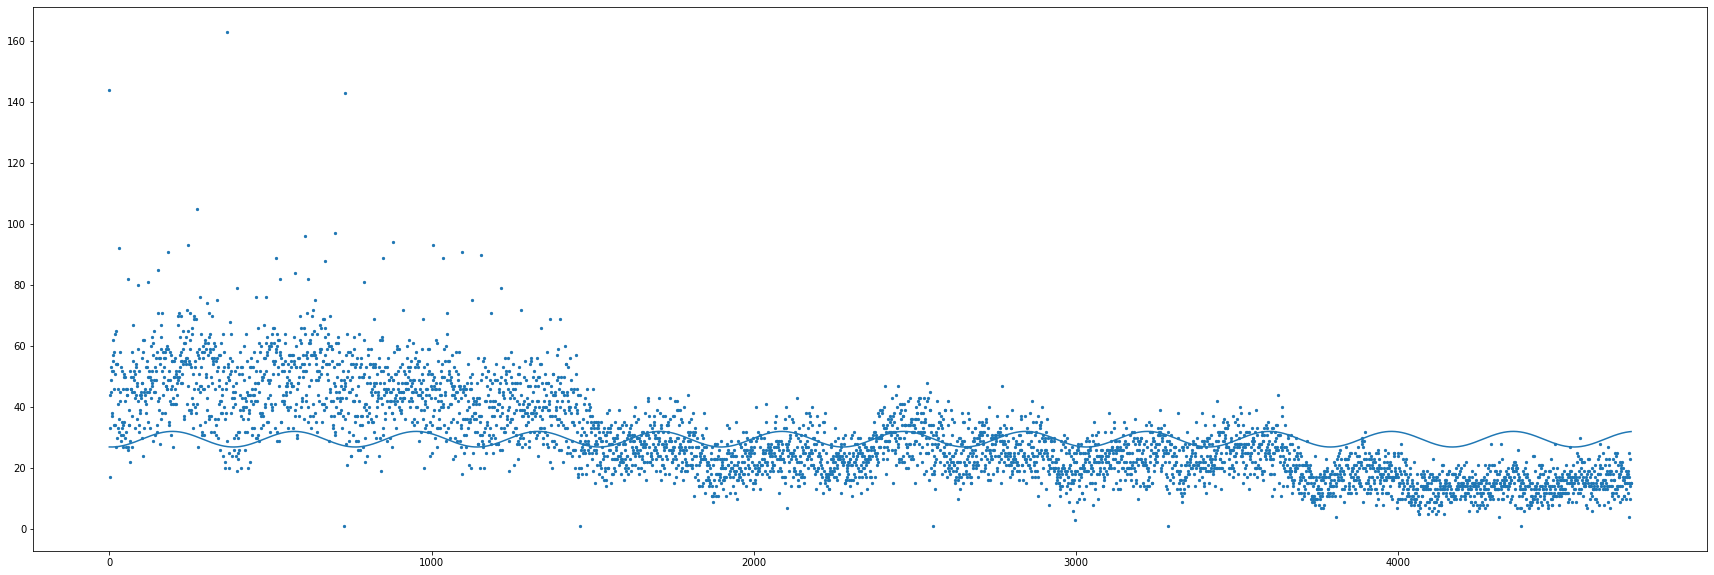

In [38]:
from scipy.optimize import curve_fit

trend_residential_crimes['day'] = np.array(trend_residential_crimes.index)
X = trend_residential_crimes['day'].values
y = trend_residential_crimes['Time_Dummy_Date'].values


param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y))

fig,ax = plt.subplots(figsize = (30,10))
plt.scatter(X, y, s=5)
plt.plot(X, sinusoid(X, *param))

Simply a sinusoidal curve is not quite sufficient, as the total number of crimes decreases gradually over time. So, to account for this, the curve will have a factor *kx* subtracted from each calculation, where *k* is the coefficient of decline

There is a decline overtime, so the next task is to determine the rate of decline.

In [39]:
trend_residential_crimes.sort_values(by=['Time_Dummy_Date'], ascending=False).head(20)

Time_Dummy_Date   day
day                        
365               163   365
0                 144     0
730               143   730
273               105   273
699                97   699
608                96   608
882                94   882
243                93   243
1004               93  1004
31                 92    31
181                91   181
1096               91  1096
1155               90  1155
1035               89  1035
516                89   516
851                89   851
669                88   669
151                85   151
577                84   577
59                 82    59

In [40]:
print(trend_residential_crimes['Time_Dummy_Date'][0])
print(trend_residential_crimes['Time_Dummy_Date'][365])
print(trend_residential_crimes['Time_Dummy_Date'][730])
print(trend_residential_crimes['Time_Dummy_Date'][1096])
print(trend_residential_crimes['Time_Dummy_Date'][1461])
print(trend_residential_crimes['Time_Dummy_Date'][1826])
print(trend_residential_crimes['Time_Dummy_Date'][2191])

144
163
143
91
44
27
26


Guessing (for now) the approximate coefficient of decline, the following curve is produced. The red curve is for current data, while the green line is the projection for the following year according to the model.

In [41]:
k = -.0063
def sinusoid_decline(x,A,offset,omega,phase):
 return (A*np.sin(omega*x+phase) + offset) + (k*x)

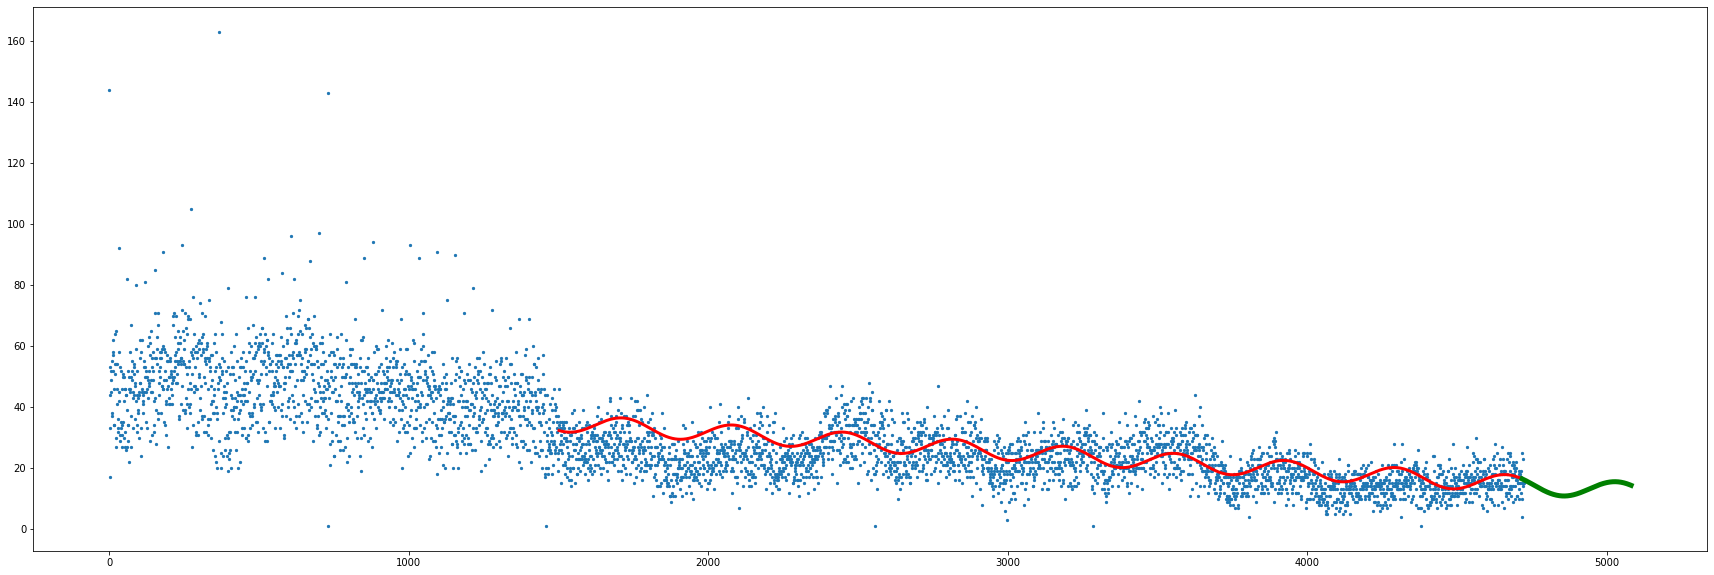

In [42]:
param_2, covariance_2 = curve_fit(sinusoid_decline, X, y, p0=get_p0(X,y))

#forecast for the next year
forecast_x = np.arange(4718, 5083, 1)

fig,ax = plt.subplots(figsize = (30,10))
plt.scatter(X, y, s=5)
plt.plot(X[1500:], sinusoid_decline(X, *param_2)[1500:], color='red', linewidth=3)
plt.plot(forecast_x, sinusoid_decline(forecast_x, *param_2), color='green',linewidth=5)

In [43]:
prediction_sin = sinusoid_decline(X, *param_2)[len(X)-10:]
actual_sin = y[len(X)-10:]

In [44]:
prediction_sin

array([16.6472543 , 16.60473843, 16.56165405, 16.51801183, 16.47382261,
       16.42909738, 16.38384729, 16.33808365, 16.29181789, 16.24506163])

In [45]:
actual_sin

array([19, 17,  4, 15, 25, 10, 14, 23, 15, 15])

The model is far from perfect, but it predicts the number of theft, burglary, or robbery crimes occuring fairly effectively, albeit conservatively. I will be working more in the future to further optimize this model, and I am open to any suggestions. 

Thanks for reading!